## Описание класса CNN

In [4]:
import sys
#!{sys.executable} -m pip install opencv-python
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models

class CNN():
    def __init__(self):
        self.model = models.Sequential()
        self.model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
        self.model.add(layers.MaxPooling2D((2, 2)))
        self.model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        self.model.add(layers.MaxPooling2D((2, 2)))
        self.model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        self.model.add(layers.Flatten())
        self.model.add(layers.Dense(64, activation='relu'))
        self.model.add(layers.Dense(3))

    def check(self):
        return self.model.summary()

    def fit(self, X_train, y_train, X_test, y_test, epochs=10):
        self.model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
        history = self.model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=epochs, verbose=0)
        return history

    def predict(self, X):
        return np.array([[np.argmax(i)] for i in self.model(X)])


## Тестирование модели

In [5]:

import numpy as np
#from sklearn.metrics import accuracy_score

from sklearn import metrics
import cv2
import matplotlib.pyplot as plt

Функция загрузки изображений

In [6]:
def data(files):
    images = []
    labels = []
    for class_ in range(len(files)):
        for file in files[class_]:
            image = cv2.imread(file)
            image = cv2.resize(image, (320, 320), interpolation=cv2.INTER_AREA)
            for i in range(0, 320, 32):
                for j in range(0, 320, 32):
                    images.append(image[i:i + 32, j:j + 32])
                    labels.append([class_])
    images = np.array(images)
    labels = np.array(labels)
    indicies = np.arange(len(labels))
    np.random.shuffle(indicies)
    images = images[indicies]
    labels = labels[indicies]
    train_ims, test_ims = np.split(images, [len(images)*8//10])
    train_lbls, test_lbls = np.split(labels, [len(images)*8//10])
    return (train_ims / 255.0, train_lbls), (test_ims / 255.0, test_lbls)


Загрузка датасета, задание тренировочной и тестовой выборки

In [7]:
(train_images, train_labels), (test_images, test_labels) = data([["VAO_E.jpg", "DAV_E.jpg", "VA_E.jpg"],
                                                                 ["VAO_U.jpg", "DAV_U.jpg", "VA_U.jpg"],
                                                                 ["VAO_Y.jpg", "DAV_Y.jpg", "VA_Y.jpg"]])


In [8]:
print(f"train size: {len(train_labels)}; test size: {len(test_labels)}")

train size: 720; test size: 180


Инициализация и обучение модели

In [9]:
model = CNN()
snaps = model.fit(train_images, train_labels, test_images, test_labels, epochs=10)
preds = model.predict(test_images)
print('Accuracy:', metrics.accuracy_score(preds, test_labels))


Accuracy: 0.9833333333333333


График обучения

In [10]:
def plot_accuracy(snaps, lim=0.5):
    plt.plot(snaps.history['accuracy'], label='accuracy')
    plt.plot(snaps.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([lim, 1])
    plt.legend(loc='lower right')
    plt.show()

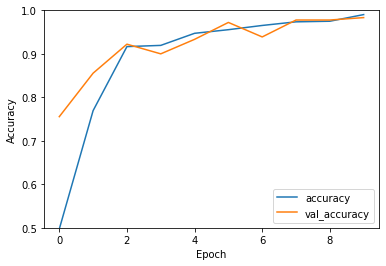

In [11]:
plot_accuracy(snaps)

Матрица ошибок

In [12]:
def plot_confusion_matrix(labels, pred_labels):
    
    fig = plt.figure(figsize = (3, 3));
    ax = fig.add_subplot(1, 1, 1);
    cm = metrics.confusion_matrix(labels, pred_labels);
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels = range(3));
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)

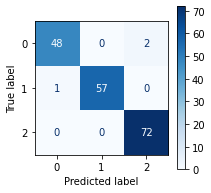

In [13]:
 plot_confusion_matrix(preds, test_labels)

# Полносвязная сеть на Keras

Реализуем теперь модель без свёртки. Библиотека с классом:

***Многослойная сеть***

In [25]:
import keras
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models


class PCT():
    def __init__(self):
        self.model = keras.Sequential([
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(3)
        ])

    def check(self):
        return self.model.summary()

    def fit(self, X_train, y_train, X_test, y_test, epochs=10):
        self.model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                               metrics=['accuracy'])
        history = self.model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0)
        return history

    def predict(self, X):
        return np.array([[np.argmax(i)] for i in self.model(X)])


Протестируем аналогично свёрточной сети:

In [26]:
(train_images, train_labels), (test_images, test_labels) = data([["VAO_E.jpg", "DAV_E.jpg", "VA_E.jpg"],
                                                                 ["VAO_U.jpg", "DAV_U.jpg", "VA_U.jpg"],
                                                                 ["VAO_Y.jpg", "DAV_Y.jpg", "VA_Y.jpg"]])


Accuracy: 0.9111111111111111


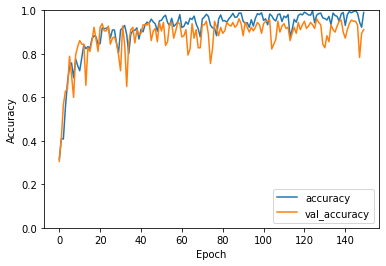

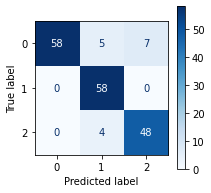

In [27]:
#кол-во эпох для вменяемого результата пришлось значительно увеличить
model = PCT()
snaps = model.fit(train_images, train_labels, test_images, test_labels, epochs=150)
preds = model.predict(test_images)
print('Accuracy:', metrics.accuracy_score(preds, test_labels))

plot_accuracy(snaps, lim=0.)
plot_confusion_matrix(preds, test_labels)


Как видно из матрицы ошибок, наиболее распространены ошибки в определении схожих классов (грустный и нейтральный смайлики), ошибки на два класса всё же редки

***Однослойная сеть***

In [20]:
class PCT():
    def __init__(self):
        self.model = keras.Sequential([
            layers.Flatten(),
            #layers.Dense(2048, activation='relu'),
            layers.Dense(3, input_shape=(32, 32, 3))
        ])

    def check(self):
        return self.model.summary()

    def fit(self, X_train, y_train, X_test, y_test, epochs=10):
        self.model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                               metrics=['accuracy'])
        history = self.model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0)
        return history

    def predict(self, X):
        return np.array([[np.argmax(i)] for i in self.model(X)])


Accuracy: 0.9222222222222223


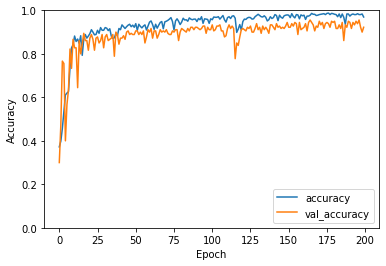

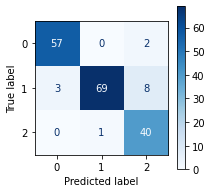

In [21]:
model = PCT()
snaps = model.fit(train_images, train_labels, test_images, test_labels, epochs=200)
preds = model.predict(test_images)
print('Accuracy:', metrics.accuracy_score(preds, test_labels))

plot_accuracy(snaps, lim=0.)
plot_confusion_matrix(preds, test_labels)

# Сравнение разных тестовых выборок

Мы тестировали сети на случайно перемешанном датасете из картинок всех участников. Теперь разделим датасет по участникам

In [ ]:
def data_split_by_student(train_files, test_files):
    all_files = (train_files, test_files)
    images = [[], []]
    labels = [[], []]
    category = 0
    for files in all_files:
        for class_ in range(len(files)):
            for file in files[class_]:
                image = cv2.imread(file)
                image = cv2.resize(image, (320, 320), interpolation=cv2.INTER_AREA)
                for i in range(0, 320, 32):
                    for j in range(0, 320, 32):
                        images[category].append(image[i:i + 32, j:j + 32])
                        labels[category].append([class_])
        images[category] = np.array(images[category])
        labels[category] = np.array(labels[category])
        indicies = np.arange(len(labels[category]))
        np.random.shuffle(indicies)
        images[category] = images[category][indicies]
        labels[category] = labels[category][indicies]
        category += 1
    return (images[0] / 255.0, labels[0]), (images[1] / 255.0, labels[1])


In [ ]:
(train_images, train_labels), (test_images, test_labels) =\
data_split_by_student([["DAV_E.jpg", "VA_E.jpg"],
                      ["DAV_U.jpg", "VA_U.jpg"], #обучающая часть
                      ["DAV_Y.jpg", "VA_Y.jpg"]], 
[["VAO_E.jpg"], ["VAO_U.jpg"], ["VAO_Y.jpg"]]) #тестовая часть


In [ ]:
print(f"train size: {len(train_labels)}; test size: {len(test_labels)}")

train size: 600; test size: 300


Accuracy: 0.5466666666666666


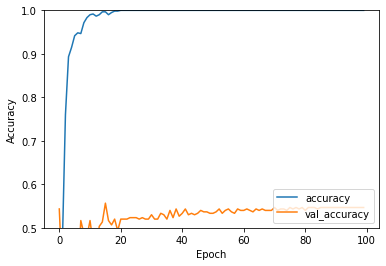

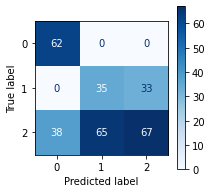

In [ ]:
model = CNN()
snaps = model.fit(train_images, train_labels, test_images, test_labels, epochs=100)
preds = model.predict(test_images)
print('Accuracy:', metrics.accuracy_score(preds, test_labels))

plot_accuracy(snaps)
plot_confusion_matrix(preds, test_labels)

Accuracy: 0.35333333333333333


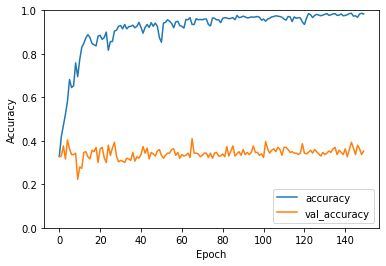

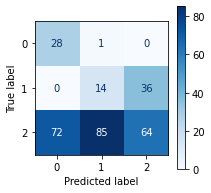

In [ ]:
model = PCT()
snaps = model.fit(train_images, train_labels, test_images, test_labels, epochs=150)
preds = model.predict(test_images)
print('Accuracy:', metrics.accuracy_score(preds, test_labels))

plot_accuracy(snaps, lim=0.)
plot_confusion_matrix(preds, test_labels)

Поменяем "обучающих" и "тестирующего"

In [ ]:
(train_images, train_labels), (test_images, test_labels) =\
data_split_by_student([["DAV_E.jpg", "VAO_E.jpg"],
                      ["DAV_U.jpg", "VAO_U.jpg"], #обучающая часть
                      ["DAV_Y.jpg", "VAO_Y.jpg"]], 
[["VA_E.jpg"], ["VA_U.jpg"], ["VA_Y.jpg"]]) #тестовая часть

Accuracy: 0.7833333333333333


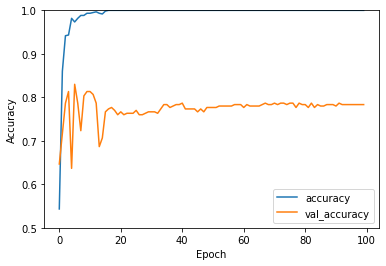

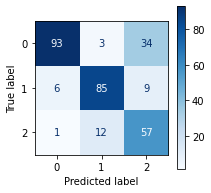

In [ ]:
model = CNN()
snaps = model.fit(train_images, train_labels, test_images, test_labels, epochs=100)
preds = model.predict(test_images)
print('Accuracy:', metrics.accuracy_score(preds, test_labels))

plot_accuracy(snaps)
plot_confusion_matrix(preds, test_labels)

Accuracy: 0.4666666666666667


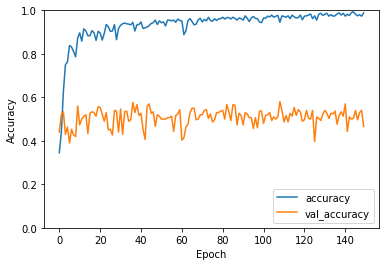

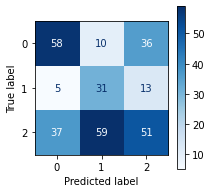

In [ ]:
model = PCT()
snaps = model.fit(train_images, train_labels, test_images, test_labels, epochs=150)
preds = model.predict(test_images)
print('Accuracy:', metrics.accuracy_score(preds, test_labels))

plot_accuracy(snaps, lim=0.)
plot_confusion_matrix(preds, test_labels)

Изменим разбиение ещё раз

In [ ]:
(train_images, train_labels), (test_images, test_labels) =\
data_split_by_student([["VA_E.jpg", "VAO_E.jpg"],
                      ["VA_U.jpg", "VAO_U.jpg"], #обучающая часть
                      ["VA_Y.jpg", "VAO_Y.jpg"]], 
[["DAV_E.jpg"], ["DAV_U.jpg"], ["DAV_Y.jpg"]]) #тестовая часть

Accuracy: 0.68


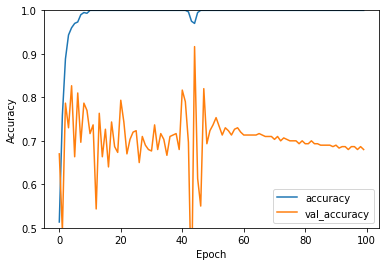

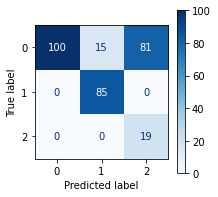

In [ ]:
model = CNN()
snaps = model.fit(train_images, train_labels, test_images, test_labels, epochs=100)
preds = model.predict(test_images)
print('Accuracy:', metrics.accuracy_score(preds, test_labels))

plot_accuracy(snaps)
plot_confusion_matrix(preds, test_labels)

Accuracy: 0.7133333333333334


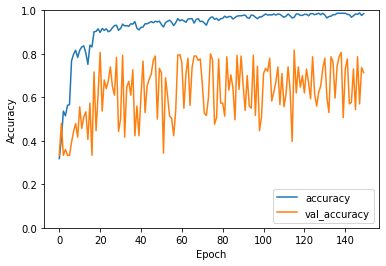

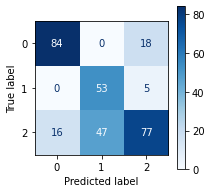

In [ ]:
model = PCT()
snaps = model.fit(train_images, train_labels, test_images, test_labels, epochs=150)
preds = model.predict(test_images)
print('Accuracy:', metrics.accuracy_score(preds, test_labels))

plot_accuracy(snaps, lim=0.)
plot_confusion_matrix(preds, test_labels)

Попробуем изменить число слоёв и нейронов в слоях полносвязной модели

In [31]:
class PCT():
    def __init__(self):
        self.model = keras.Sequential([
            layers.Flatten(),
            #layers.Dense(2048, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(3)
        ])

    def check(self):
        return self.model.summary()

    def fit(self, X_train, y_train, X_test, y_test, epochs=10):
        self.model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                               metrics=['accuracy'])
        history = self.model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0)
        return history

    def predict(self, X):
        return np.array([[np.argmax(i)] for i in self.model(X)])


Accuracy: 0.9166666666666666


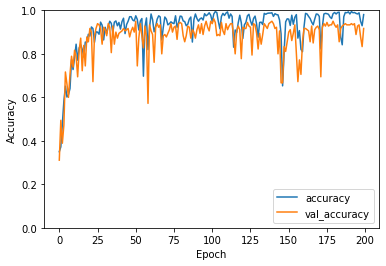

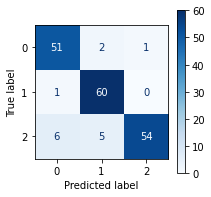

In [32]:
model = PCT()
snaps = model.fit(train_images, train_labels, test_images, test_labels, epochs=200)
preds = model.predict(test_images)
print('Accuracy:', metrics.accuracy_score(preds, test_labels))

plot_accuracy(snaps, lim=0.)
plot_confusion_matrix(preds, test_labels)